## Ordinary LMS

Materials from:

- https://see.stanford.edu/materials/aimlcs229/cs229-notes1.pdf
- http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex3/ex3.html

In [1]:
import pathlib
import numpy as np
import sys

path = pathlib.Path().absolute()
sys.path.insert(0, str(path.parent))

xdata = np.loadtxt(f"{path}/ex3Data/ex3x.dat", unpack=True).T
ydata = np.loadtxt(f"{path}/ex3Data/ex3y.dat", unpack=True)[:, np.newaxis]

print(xdata.shape, ydata.shape)

(47, 2) (47, 1)


In [2]:
class LMS:
    def __init__(self, max_iter=100, alpha=None, scale=True):
        if alpha is None:
            alpha = [0.01, 0.03, 0.1, 0.3, 1, 1.3]
        if not isinstance(alpha, list):
            alpha = [alpha]

        self.max_iter = max_iter
        self.alpha = alpha
        self.scale = scale

    @staticmethod
    def add_intercept_term(X):
        m, _ = X.shape
        return np.hstack((np.ones((m, 1)), X))

    @staticmethod
    def normal_scaling(X, ignore_first=True):
        mu = X.mean(axis=0)
        std = np.std(X, axis=0, ddof=1) + 1e-10
        X_ = X.copy()
        idx = 1 if ignore_first else 0
        X_[:, idx:] = (X[:, idx:] - mu[idx:]) / std[idx:]
        return X_, mu, std

    @staticmethod
    def initiate(length, method='zeros'):
        opts = ['zeros']
        assert method in opts, (
            f"Invalid option, choose among {opts}.")

        if method == 'zeros':
            return np.zeros((length, 1))

    def fit(self, X, y):
        """Run the LMS algorithm."""
        m, d = X.shape
        X_ = LMS.add_intercept_term(X)
        if self.scale:
            X_, mu, std = LMS.normal_scaling(X_, ignore_first=True)
            self.mu_ = mu
            self.std_ = std

        res = dict()
        for lr in self.alpha:
            theta = LMS.initiate(length=d + 1, method='zeros')
            J = np.zeros(self.max_iter)

            for idx_iter in range(self.max_iter):
                err = X_ @ theta - y

                # Calculate the J term, which is the current MSE
                J[idx_iter] = (0.5/m) * err.T @ err

                # The gradient
                grad = (1/m) * np.conjugate(X_).T @ err

                # Here is the actual update
                theta = theta - lr * grad
            res[lr] = dict(result=theta, cost=J)

        self.res = res
        idx_lower_cost = np.argmin([v['cost'][-1] for k, v in res.items()])
        self.best_lr = self.alpha[idx_lower_cost]

        return self

    def predict(self, X):
        X_ = LMS.add_intercept_term(X)
        if self.scale:
            X_[:, 1:] = (X_[:, 1:] - self.mu_[1:]) / self.std_[1:]
        best_theta = self.res[self.best_lr]['result']
        return X_ @ best_theta

In [3]:
MAX_ITR = 100
lms = LMS(max_iter=MAX_ITR, alpha=None, scale=True)
lms.fit(xdata, y=ydata)

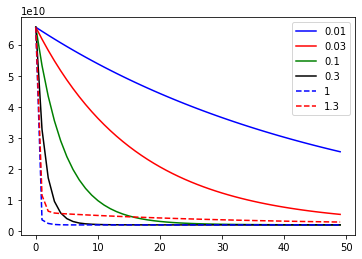

In [4]:
import matplotlib.pyplot as plt

plotstyle = ['b', 'r', 'g', 'k', 'b--', 'r--']

plt.figure()
for i, val in enumerate(lms.res.keys()):
    plt.plot(
        np.arange(MAX_ITR)[:50],
        lms.res[val]['cost'][:50],
        plotstyle[i],
        label=val)

plt.legend(loc="upper right")

plt.show()

## Applying the validated implementation on a real-weighted graph

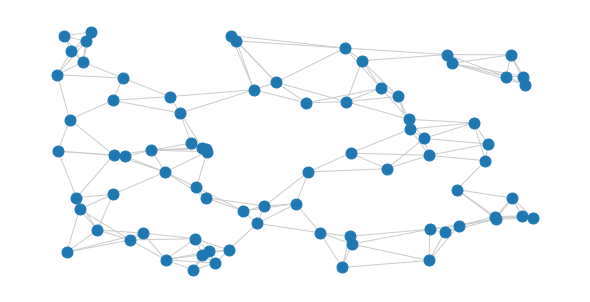

In [5]:
from gspx.utils.graph import make_sensor
from gspx.utils.display import plot_graph
from gspx.utils.graph import graph_total_variation

A, coords = make_sensor(N=80)
plot_graph(
    A, coords=coords,
    figsize=(8, 4), colormap='viridis',
    node_size=120)

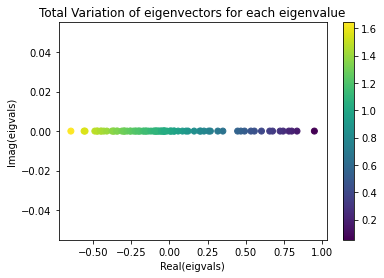

In [6]:
import matplotlib.pyplot as plt

eigvals, V = np.linalg.eig(A)
tv = graph_total_variation(V, A)

plt.scatter(np.real(eigvals), np.imag(eigvals), c=tv)
plt.colorbar()
plt.title("Total Variation of eigenvectors for each eigenvalue")
plt.xlabel("Real(eigvals)")
plt.ylabel("Imag(eigvals)")
plt.show()

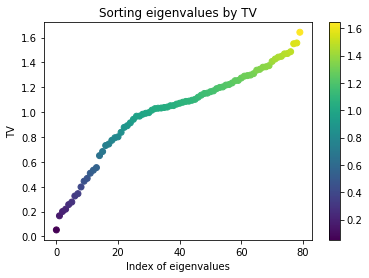

In [7]:
idx_freq = np.argsort(tv)

plt.figure()
plt.scatter(np.arange(len(idx_freq)), tv[idx_freq], c=tv[idx_freq])
plt.xlabel("Index of eigenvalues")
plt.ylabel("TV")
plt.title("Sorting eigenvalues by TV")
plt.colorbar()
plt.show()

### Ideal filter response

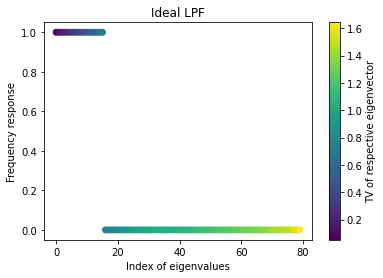

In [8]:
h_ideal = np.zeros(len(idx_freq))

# Bandwith of 20% the frequency support
bandwidth = int(len(idx_freq) / 5)
h_ideal[idx_freq[:bandwidth]] = 1

plt.figure()
plt.scatter(np.arange(len(idx_freq)), h_ideal[idx_freq], c=tv[idx_freq])
plt.xlabel("Index of eigenvalues")
plt.ylabel("Frequency response")
cbar = plt.colorbar()
cbar.set_label("TV of respective eigenvector", rotation=90)
plt.title("Ideal LPF")
plt.show()

In [11]:
# Heat kernel
k = 0.2
ss = np.exp(-k * np.arange(len(idx_freq)))

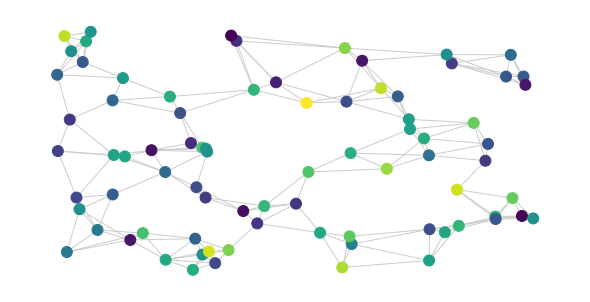

In [10]:
from gspx.utils.gsp import gft, igft

s = igft(A, ss)

plot_graph(
    A, coords=coords, colors=s,
    figsize=(8, 4), colormap='viridis',
    node_size=120)

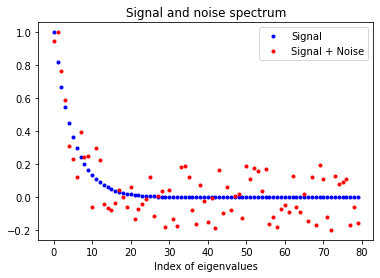

In [31]:
rnd = np.random.RandomState(seed=42)
err_amplitude = 0.2
nn = rnd.uniform(low=-err_amplitude, high=err_amplitude, size=len(ss))

sn = igft(A, ss + nn)

plt.figure()
plt.plot(np.arange(len(idx_freq)), ss, 'b.', label="Signal")
plt.plot(np.arange(len(idx_freq)), ss + nn, 'r.', label="Signal + Noise")
plt.xlabel("Index of eigenvalues")
plt.title("Signal and noise spectrum")
plt.legend(loc="upper right")
plt.show()

In [32]:
MAX_ITR = 1000
deg = 7

eig_vander = np.vander(eigvals, N=deg, increasing=True)
theta_ideal = h_ideal[:, np.newaxis]
print(eig_vander.shape, theta_ideal.shape)

learning_rates = [0.001, 0.01, 0.1, 0.3]

lms = LMS(max_iter=MAX_ITR, alpha=learning_rates, scale=True)
lms.fit(eig_vander, y=theta_ideal)

(80, 7) (80, 1)


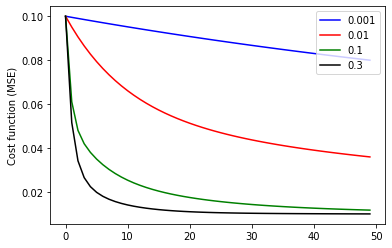

In [33]:
import matplotlib.pyplot as plt

plotstyle = ['b', 'r', 'g', 'k', 'b--', 'r--']

plt.figure()
for i, val in enumerate(lms.res.keys()):
    plt.plot(
        np.arange(MAX_ITR)[:50],
        lms.res[val]['cost'][:50],
        plotstyle[i],
        label=val)
plt.ylabel("Cost function (MSE)")
plt.legend(loc="upper right")

plt.show()

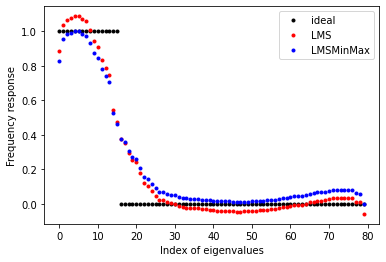

In [34]:
h_opt = lms.predict(eig_vander)

h_opt_ = (h_opt - h_opt.min()) / (h_opt.max() - h_opt.min())

plt.figure()
plt.plot(np.arange(len(idx_freq)), h_ideal[idx_freq], 'k.', label="ideal")
plt.plot(np.arange(len(idx_freq)), h_opt[idx_freq], 'r.', label="LMS")
plt.plot(np.arange(len(idx_freq)), h_opt_[idx_freq], 'b.', label="LMSMinMax")
plt.xlabel("Index of eigenvalues")
plt.ylabel("Frequency response")
plt.legend(loc="upper right")
plt.show()

### Removing noise with the adaptive filter

In [36]:
print("MSE prior:", np.mean((s - sn)**2))

MSE prior: 0.014951009268568871


In [37]:
s_lpf = igft(A, (ss + nn) * h_opt.ravel())

print("MSE post:", np.mean((s - s_lpf)**2))

MSE post: 0.003642338644882645


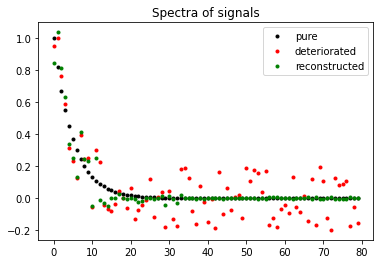

In [40]:
plt.figure()
plt.plot(np.arange(len(idx_freq)), np.abs(ss), 'k.', label="pure")
plt.plot(np.arange(len(idx_freq)), (ss + nn), 'r.', label="deteriorated")
plt.plot(np.arange(len(idx_freq)), (ss + nn) * h_opt.ravel(), 'g.', label="reconstructed")
plt.legend(loc="upper right")
plt.title("Spectra of signals")
plt.show()